# Notebook with analysis and visualizations

### **Research Questions**  

### **1. General Relationship Between Firearms and Crime**
- What is the general relationship between the total number of firearms per 1,000 citizens and crime rates (homicide, sexual & violent crimes, combined crime rate)? 

### **2. Impact of Weapon Ownership Types on Crime**
- How do different types of firearm ownership affect crime rates in countries with similar total firearm counts, and how does this effect change as firearm prevalence increases?

### **3. Effect of Government vs. Civilian-Owned Weapons**
- How does the ratio between government and civilian-owned firearms impact crime statistics?

## Loading dependencies and data

In [2]:
%pip install seaborn geopandas statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
import statsmodels.api as sm
import scipy.stats as stats

# Load the dataset
file = '../new-data/everything_merged_dataset_no_NULL_violent&sexual.csv'
data = pd.read_csv(file)

## Visualize data
Some visualization of data before analyses, to get an idea of what the data looks like

In [5]:
# We use the columns with the per 1000 data
columns_per_1000 = [
    "Total Homicides per 1,000",
    "Total Sexual and Violent Crime Rates per 1,000",
    "Combined Crime Rate per 1,000",
    "Total Firearms per 1,000",
    "Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000"
]

# And now we create histograms to visualize distribution of data
"""for column in columns_per_1000:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=30, kde=True, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()"""

'for column in columns_per_1000:\n    plt.figure(figsize=(8, 6))\n    sns.histplot(data[column], bins=30, kde=True, color=\'blue\')\n    plt.title(f"Distribution of {column}")\n    plt.xlabel(column)\n    plt.ylabel("Frequency")\n    plt.tight_layout()\n    plt.show()'

### Global statistics on crime and small arms presence

<Figure size 2500x2000 with 0 Axes>

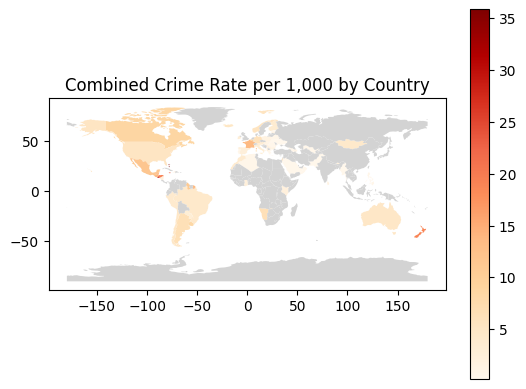

<Figure size 2500x2000 with 0 Axes>

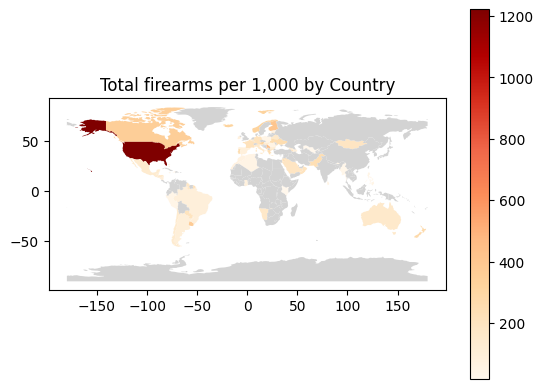

In [27]:
# Create world maps
file_path = "../new-data/geo/ne_110m_admin_0_countries.shx" # world map data
world = gpd.read_file(file_path)
world = world.rename(columns={"NAME": "Country"})

# Merge data with world map
map_data = world.merge(data, on="Country", how="left")

# Plot Combined Crime Rate per 1,000
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Combined Crime Rate per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Combined Crime Rate per 1,000 by Country")
plt.show()

# Plot Total firearms per 1,000 by Country
plt.figure(figsize=(25, 20))
map_data.plot(
    column="Total Firearms per 1,000",
    cmap="OrRd",
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No data"},
)
plt.title("Total firearms per 1,000 by Country")
plt.show()

## Analyses of Questions


### **First off - grouping countries**:
Here we categories countries based on the total number of weapons per 1000 people into 3 groups: Low, Medium, High (firearms ownership), we use the column "Total Firearms per 1,000", which is a sum per country of the total civilan, military and law enforcement weapons. 

We also calculate the proportions for each type of gun ownership.

In [28]:
data["Total Firearms Group"] = pd.qcut(
    data["Total Firearms per 1,000"], q=3, labels=["Low", "Medium", "High"]
)

Here we make a plot to get an idea for each group how the weapons are roughly distributed accross the groups. This step is not crucial for the analysis, but it helps us understand the data we are dealing with. Just like we made some visualization in the beginning

/var/folders/9j/jqs2fbzx1nl_9hlbbtdrlqrr0000gn/T/ipykernel_75459/4263442305.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_means_within_group = data.groupby("Total Firearms Group")[


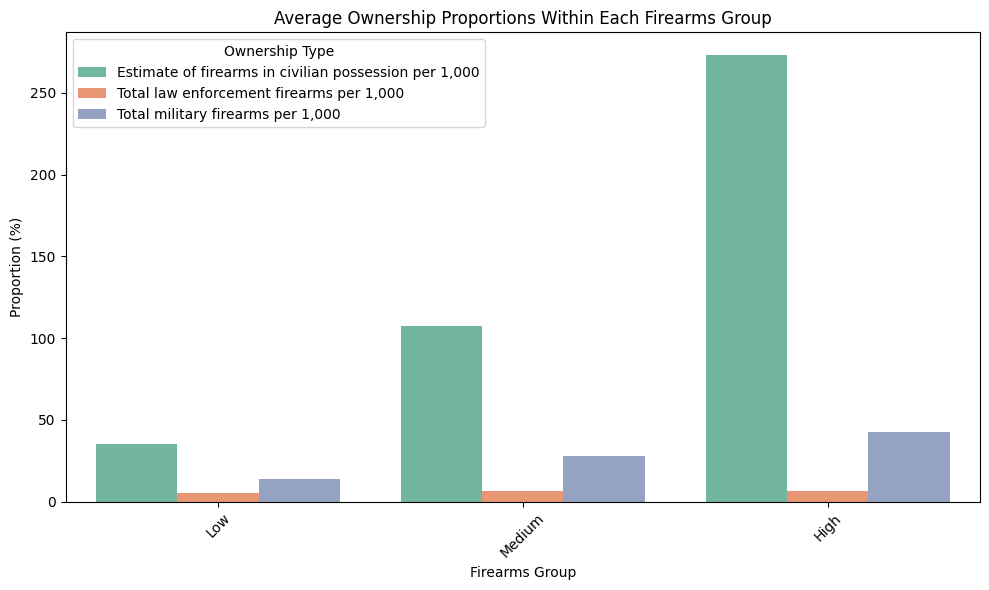

In [29]:
# Compute mean crime rates by firearm group & ownership proportions
crime_means_within_group = data.groupby("Total Firearms Group")[
    ["Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000",
     "Total Homicides per 1,000", 
     "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
].mean().reset_index()

# Plot bar chart for ownership proportions
plt.figure(figsize=(10, 6))
ownership_melted = crime_means_within_group.melt(id_vars="Total Firearms Group", value_vars=["Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000"])
sns.barplot(data=ownership_melted, x="Total Firearms Group", y="value", hue="variable", palette="Set2")

plt.title("Average Ownership Proportions Within Each Firearms Group")
plt.xlabel("Firearms Group")
plt.ylabel("Proportion (%)")
plt.legend(title="Ownership Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Analysis for Question 1.**
### What is the general relationship between the total number of firearms per 1,000 citizens and crime rates (homicide, sexual & violent crimes, combined crime rate)? 

#### Below we calculate the correlations and visualize them

Correlations between weapons and crime types:
{'Total Homicides per 1,000': -0.037330999825714604, 'Total Sexual and Violent Crime Rates per 1,000': 0.12020625637442964, 'Combined Crime Rate per 1,000': 0.038990344818663335}


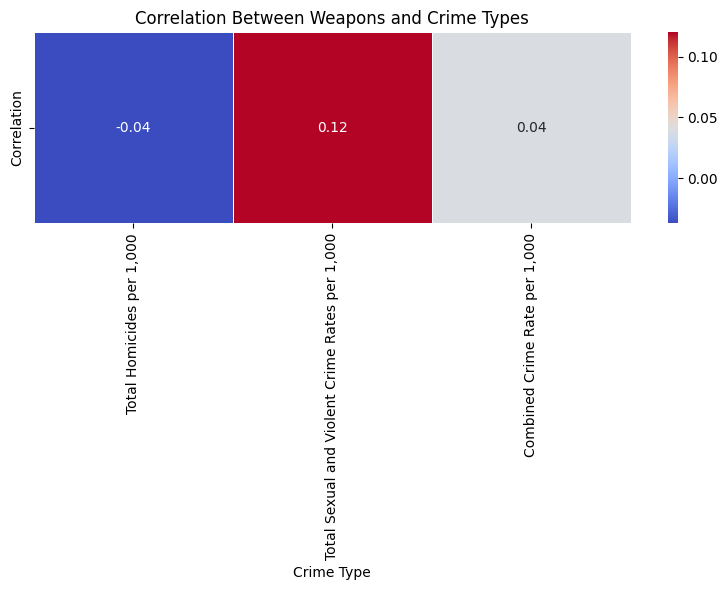

In [30]:
# General Relationship Between Weapons and Crime Types
crime_columns = ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
weapon_column = "Total Firearms per 1,000"

# Correlations between weapons and crime types
correlations = {}
for crime in crime_columns:
    correlation, _ = pearsonr(data[weapon_column], data[crime])
    correlations[crime] = correlation

print("Correlations between weapons and crime types:")
print(correlations)

# Create heatmap
correlation_data = pd.DataFrame(list(correlations.items()), columns=["Crime Type", "Correlation"])
plt.figure(figsize=(8, 6))  
sns.heatmap(
    correlation_data.set_index("Crime Type").T,
    annot=True,
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlation Between Weapons and Crime Types")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Here we create scatterplots to see the relationship between total weapons vs each crime type for the countries in different groups

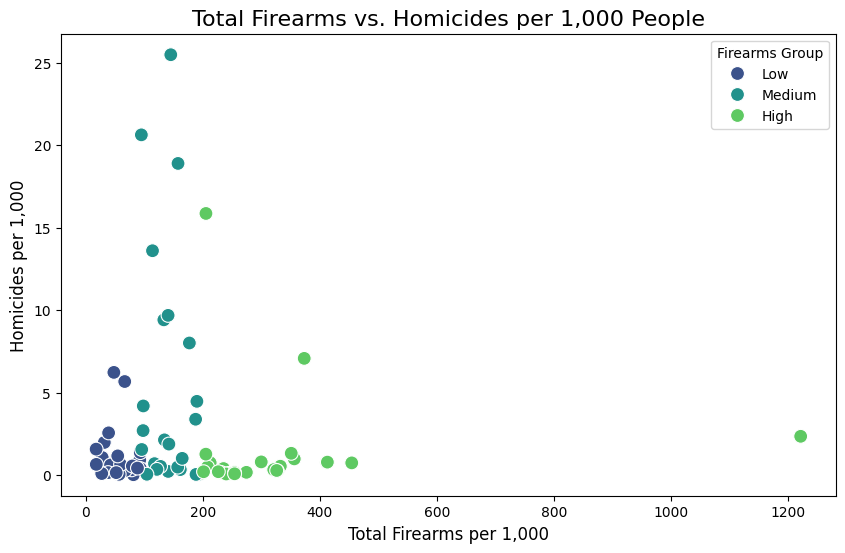

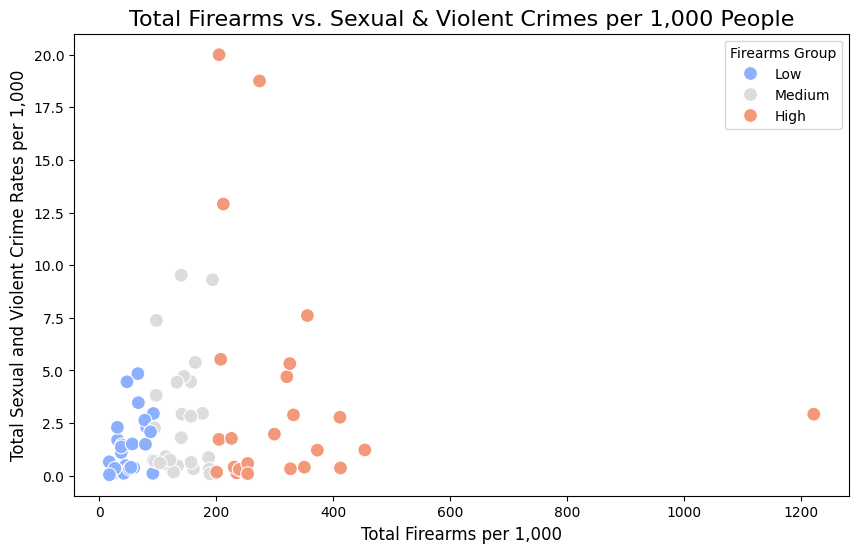

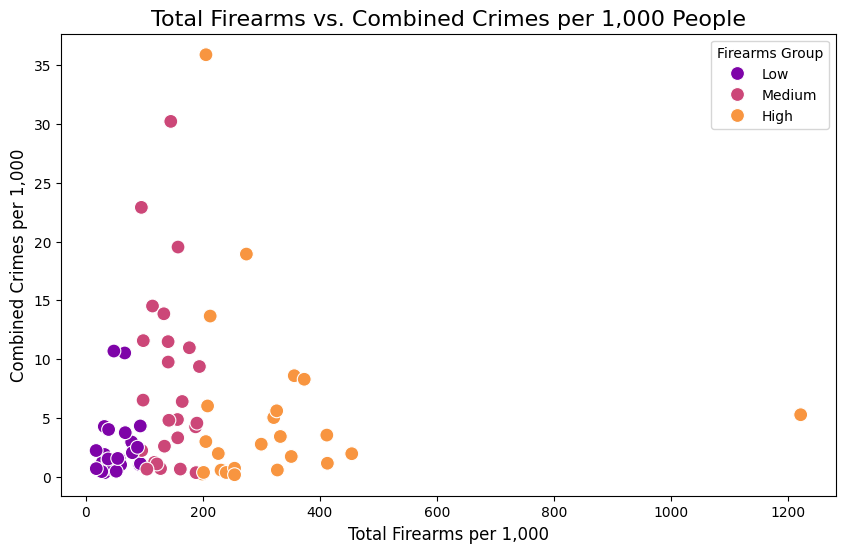

In [31]:
# Scatterplot: Total firearms vs. Homicides
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Total Homicides per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="viridis", 
    s=100
)
plt.title("Total Firearms vs. Homicides per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Homicides per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

# Repeat for Violent Crimes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Total Sexual and Violent Crime Rates per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="coolwarm", 
    s=100
)
plt.title("Total Firearms vs. Sexual & Violent Crimes per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Total Sexual and Violent Crime Rates per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

# Repeat for Total Crimes
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Total Firearms per 1,000", 
    y="Combined Crime Rate per 1,000", 
    data=data, 
    hue="Total Firearms Group", 
    palette="plasma", 
    s=100
)
plt.title("Total Firearms vs. Combined Crimes per 1,000 People", fontsize=16)
plt.xlabel("Total Firearms per 1,000", fontsize=12)
plt.ylabel("Combined Crimes per 1,000", fontsize=12)
plt.legend(title="Firearms Group")
plt.show()

#### The analysis uses a Negative Binomial regression, which is appropriate for count-based crime data that typically exhibit overdispersion (variance > mean). The model includes the main effect of total firearms to examine whether higher firearm ownership increases or decreases crime rates. For combined crime rates, a quadratic term is included to capture potential non-linear relationships, where the effect of firearms on crime may change as firearm levels increase. GDP is included too as a confounding variable and an interaction term 


In [32]:
# Define crimes and results storage
crime_types = [
    "Total Homicides per 1,000", 
    "Total Sexual and Violent Crime Rates per 1,000", 
    "Combined Crime Rate per 1,000"
]
nb_results_final = {}

# Create interaction term and quadratic term 
data["Total_Firearms_Squared"] = data["Total Firearms per 1,000"]**2
# Interaction term for exploring varying relationships based on economic conditions
data["Firearms_GDP_Interaction"] = data["Total Firearms per 1,000"] * data["Country GDP per 1,000"]

for crime in crime_types:
    if crime == "Combined Crime Rate per 1,000":
        X = data[[
            "Total Firearms per 1,000", 
            "Total_Firearms_Squared", 
            "Country GDP per 1,000", 
            "Firearms_GDP_Interaction"
        ]]
    else:
        X = data[[
            "Total Firearms per 1,000", 
            "Country GDP per 1,000", 
            "Firearms_GDP_Interaction"
        ]]
    
    X = sm.add_constant(X) 
    y = data[crime] 

    try:
        # Fit Negative Binomial regression
        model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
        nb_results_final[crime] = model.summary()
    except Exception as e:
        print(f"Skipping {crime} due to error: {e}")

for crime, result in nb_results_final.items():
    print(f"\nNegative Binomial Regression Results for {crime}:\n")
    print(result)


Negative Binomial Regression Results for Total Homicides per 1,000:

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       73
Model Family:               NegativeBinomial   Df Model:                            3
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -154.49
Date:                       Fri, 31 Jan 2025   Deviance:                       96.589
Time:                               15:38:22   Pearson chi2:                     169.
No. Iterations:                           12   Pseudo R-squ. (CS):             0.1777
Covariance Type:                   nonrobust                                         
                               coef    std err          z      P>|z|  

/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


# **Analysis for Question 2.**

Below is the statistical testing, where we first used Negative Binomial regression to estimate the effects of firearm ownership types on type of crime (including combined crime rate)  within each group. Then we performed Wald tests to assess whether these effects differed significantly across firearm-ownership categories. Then we tested whether the relationship between firearm ownership type and crime changed as total firearm ownership increased by including interaction models. We included GDP as an independent variable so we can check whether it is confounding. 

### Negative Binomial regression 

In [33]:
group_results = {}
group_coefficients = {}

# for each group
for group in data["Total Firearms Group"].unique():
    group_data = data[data["Total Firearms Group"] == group]
    
    # independent variables 
    X = group_data[[
        "Estimate of firearms in civilian possession per 1,000",
        "Total law enforcement firearms per 1,000",
        "Total military firearms per 1,000",
        "Country GDP per 1,000" # add GDP
    ]]
    X = sm.add_constant(X)

    # for each crime type
    for crime in ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]:
        y = group_data[crime]
        
        # fit the Negative Binomial regression
        model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
        
        group_results[(group, crime)] = model
        group_coefficients[group] = model.params
        
        print(f"\nNegative Binomial Regression Results for Group: {group}, Crime Type: {crime}\n")
        print(model.summary())


Negative Binomial Regression Results for Group: Medium, Crime Type: Total Homicides per 1,000

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   25
Model:                                   GLM   Df Residuals:                       20
Model Family:               NegativeBinomial   Df Model:                            4
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -56.971
Date:                       Fri, 31 Jan 2025   Deviance:                       15.780
Time:                               15:38:22   Pearson chi2:                     13.4
No. Iterations:                           10   Pseudo R-squ. (CS):             0.6040
Covariance Type:                   nonrobust                                         
                                            

/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using d

### Wald tests

In [34]:
from scipy.stats import chi2

# coef for all three crime types
coefficients = {
    "Homicides": {
        "Low": [0.0026, -0.0294, 0.0782],
        "Medium": [0.0006, -0.0181, -0.0457],
        "High": [0.0015, -0.0101, 0.2803]
    },
    "Sexual and Violent Crimes": {
        "Low": [0.0144, -0.0092, 0.0093],
        "Medium": [0.0055, 0.0004, 0.0459],
        "High": [-0.0016, -0.0141, 0.0942]
    },
    "Combined Crime Rates": {
        "Low": [0.0095, -0.0168, 0.0269],
        "Medium": [0.0018, -0.0043, -0.0060],
        "High": [-0.0007, -0.0108, 0.1445]
    }
}

# st errors for all three crime types
std_errors = {
    "Homicides": {
        "Low": [0.013, 0.029, 0.082],
        "Medium": [0.009, 0.012, 0.039],
        "High": [0.001, 0.007, 0.098]
    },
    "Sexual and Violent Crimes": {
        "Low": [0.012, 0.022, 0.075],
        "Medium": [0.008, 0.010, 0.038],
        "High": [0.001, 0.008, 0.093]
    },
    "Combined Crime Rates": {
        "Low": [0.011, 0.020, 0.068],
        "Medium": [0.007, 0.009, 0.035],
        "High": [0.001, 0.006, 0.081]
    }
}

# build covariance matrices
def build_cov_matrices(errors):
    return {group: np.diag(np.array(errors[group]) ** 2) for group in errors.keys()}

# perform Wald test
def wald_test(coef1, coef2, var1, var2):
    delta = np.array([[coef1 - coef2]])  
    cov_delta = np.array([[var1 + var2]])  
    wald_stat = delta.T @ np.linalg.inv(cov_delta) @ delta  
    p_value = 1 - chi2.cdf(wald_stat[0, 0], df=1) 
    return wald_stat[0, 0], p_value

final_results = {}

for crime_type in coefficients.keys():
    cov_matrices = build_cov_matrices(std_errors[crime_type])  # build covariance matrices for the currenrt crime type
    
    final_results[crime_type] = {
        "Civilian Firearms (Low vs Medium)": wald_test(coefficients[crime_type]["Low"][0], coefficients[crime_type]["Medium"][0], cov_matrices["Low"][0, 0], cov_matrices["Medium"][0, 0]),
        "Civilian Firearms (Medium vs High)": wald_test(coefficients[crime_type]["Medium"][0], coefficients[crime_type]["High"][0], cov_matrices["Medium"][0, 0], cov_matrices["High"][0, 0]),
        "Military Firearms (Low vs Medium)": wald_test(coefficients[crime_type]["Low"][1], coefficients[crime_type]["Medium"][1], cov_matrices["Low"][1, 1], cov_matrices["Medium"][1, 1]),
        "Military Firearms (Medium vs High)": wald_test(coefficients[crime_type]["Medium"][1], coefficients[crime_type]["High"][1], cov_matrices["Medium"][1, 1], cov_matrices["High"][1, 1]),
        "Law Enforcement Firearms (Low vs Medium)": wald_test(coefficients[crime_type]["Low"][2], coefficients[crime_type]["Medium"][2], cov_matrices["Low"][2, 2], cov_matrices["Medium"][2, 2]),
        "Law Enforcement Firearms (Medium vs High)": wald_test(coefficients[crime_type]["Medium"][2], coefficients[crime_type]["High"][2], cov_matrices["Medium"][2, 2], cov_matrices["High"][2, 2])
    }

for crime_type, results in final_results.items():
    print(f"\n=== Wald Test Results for {crime_type} ===")
    for test, result in results.items():
        print(f"{test}: Wald Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")


=== Wald Test Results for Homicides ===
Civilian Firearms (Low vs Medium): Wald Statistic = 0.0160, p-value = 0.8993
Civilian Firearms (Medium vs High): Wald Statistic = 0.0099, p-value = 0.9208
Military Firearms (Low vs Medium): Wald Statistic = 0.1296, p-value = 0.7188
Military Firearms (Medium vs High): Wald Statistic = 0.3316, p-value = 0.5647
Law Enforcement Firearms (Low vs Medium): Wald Statistic = 1.8619, p-value = 0.1724
Law Enforcement Firearms (Medium vs High): Wald Statistic = 9.5529, p-value = 0.0020

=== Wald Test Results for Sexual and Violent Crimes ===
Civilian Firearms (Low vs Medium): Wald Statistic = 0.3808, p-value = 0.5372
Civilian Firearms (Medium vs High): Wald Statistic = 0.7755, p-value = 0.3785
Military Firearms (Low vs Medium): Wald Statistic = 0.1578, p-value = 0.6912
Military Firearms (Medium vs High): Wald Statistic = 1.2820, p-value = 0.2575
Law Enforcement Firearms (Low vs Medium): Wald Statistic = 0.1895, p-value = 0.6633
Law Enforcement Firearms (Med

#### Here we plot the coefficients from the Negative Binominal Regression we did

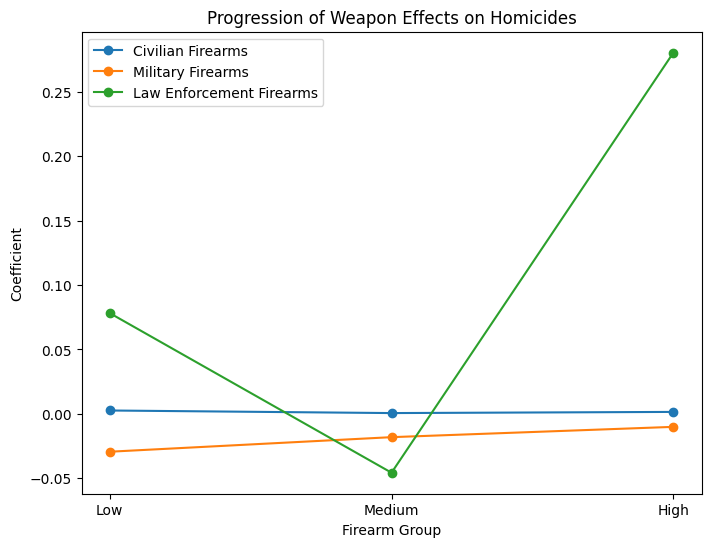

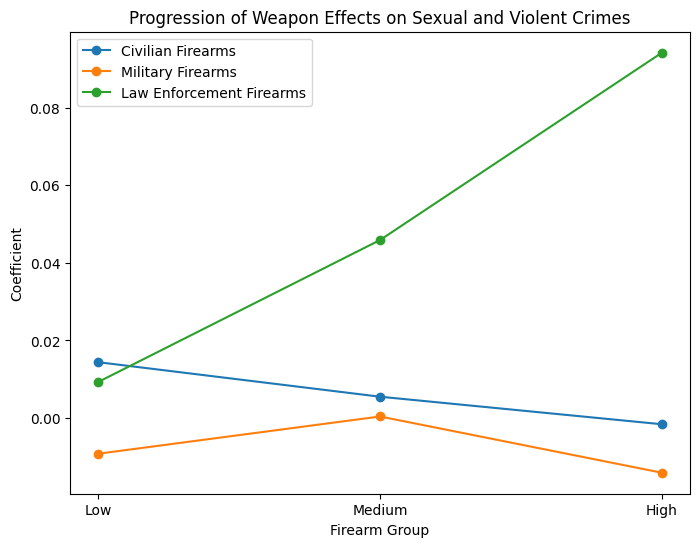

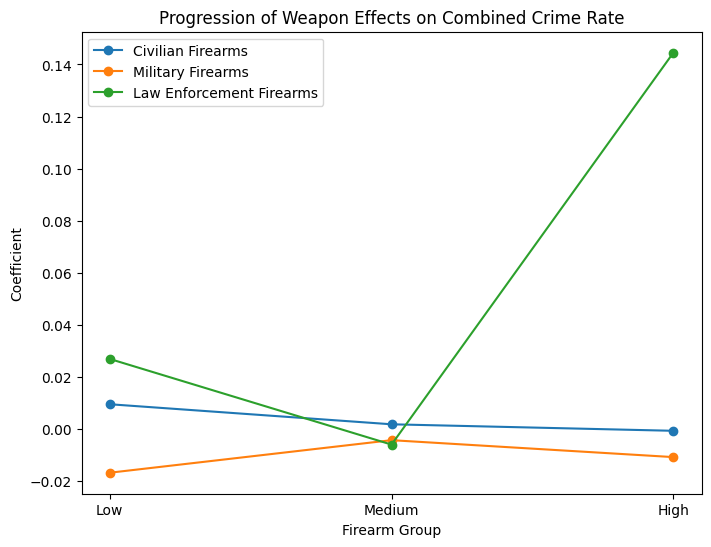

In [35]:
groups = ["Low", "Medium", "High"]

civilian_homicides = [0.0026, 0.0006, 0.0015]
civilian_sexual_violent = [0.0144, 0.0055, -0.0016]
civilian_combined = [0.0095, 0.0018, -0.0007]

military_homicides = [-0.0294, -0.0181, -0.0101]
military_sexual_violent = [-0.0092, 0.0004, -0.0141]
military_combined = [-0.0168, -0.0043, -0.0108]

law_enforcement_homicides = [0.0782, -0.0457, 0.2803]
law_enforcement_sexual_violent = [0.0093, 0.0459, 0.0942]
law_enforcement_combined = [0.0269, -0.0060, 0.1445]

# Function to plot for each crime type
def plot_progression(coefs_civilian, coefs_military, coefs_law_enforcement, title):
    plt.figure(figsize=(8, 6))
    plt.plot(groups, coefs_civilian, marker='o', linestyle='-', label='Civilian Firearms')
    plt.plot(groups, coefs_military, marker='o', linestyle='-', label='Military Firearms')
    plt.plot(groups, coefs_law_enforcement, marker='o', linestyle='-', label='Law Enforcement Firearms')
    plt.title(f'Progression of Weapon Effects on {title}')
    plt.xlabel('Firearm Group')
    plt.ylabel('Coefficient')
    plt.legend()
    plt.show()

# Plotting for each crime type
plot_progression(civilian_homicides, military_homicides, law_enforcement_homicides, 'Homicides')
plot_progression(civilian_sexual_violent, military_sexual_violent, law_enforcement_sexual_violent, 'Sexual and Violent Crimes')
plot_progression(civilian_combined, military_combined, law_enforcement_combined, 'Combined Crime Rate')

### Investigate how the different ownership types affect the crimes as the total number of weapons increases (again with a Negative Binomial Regression)

In [36]:
data["Civilian_Firearms_Interaction"] = data["Estimate of firearms in civilian possession per 1,000"] * data["Total Firearms per 1,000"]
data["LawEnforcement_Firearms_Interaction"] = data["Total law enforcement firearms per 1,000"] * data["Total Firearms per 1,000"]
data["Military_Firearms_Interaction"] = data["Total military firearms per 1,000"] * data["Total Firearms per 1,000"]

interaction_results = {}
interaction_coefficients = {}

crime_types = ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]

# ind var
X = data[[
    "Estimate of firearms in civilian possession per 1,000",
    "Total law enforcement firearms per 1,000",
    "Total military firearms per 1,000",
    "Civilian_Firearms_Interaction",
    "LawEnforcement_Firearms_Interaction",
    "Military_Firearms_Interaction",
    "Country GDP per 1,000" # note we include GDP again!
]]
X = sm.add_constant(X)

for crime in crime_types:
    y = data[crime]
    
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    
    interaction_results[crime] = model
    interaction_coefficients[crime] = model.params
    
    print(f"\nNegative Binomial Regression Results for Crime Type: {crime}\n")
    print(model.summary())


Negative Binomial Regression Results for Crime Type: Total Homicides per 1,000

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       69
Model Family:               NegativeBinomial   Df Model:                            7
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -147.74
Date:                       Fri, 31 Jan 2025   Deviance:                       83.084
Time:                               15:38:23   Pearson chi2:                     124.
No. Iterations:                           13   Pseudo R-squ. (CS):             0.3100
Covariance Type:                   nonrobust                                         
                                                           

/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


##  **Question 3.**

### How does the ratio between government and civilian-owned firearms impact crime statistics?

Here we applied a Negative Binomial regression to model its effect on homicide, violent and sexual crimes, and combined crime rates. Here, we also controlled for the GDP variable by including it as an independent variable. Then we can see whether it is a confounding variable. 

In [37]:
# Create the government-to-civilian ratio variable
data["Gov_to_Civilian_Ratio"] = (data["Total law enforcement firearms per 1,000"] + data["Total military firearms per 1,000"]) / data["Estimate of firearms in civilian possession per 1,000"]

gov_ratio_results = {}
crime_types = ["Total Homicides per 1,000",
               "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]

# Define and fit the model for each crime type
for crime in crime_types:
    X = data[[
        "Gov_to_Civilian_Ratio",
        "Country GDP per 1,000"  # Control for economic conditions
    ]]
    
    X = sm.add_constant(X)  
    y = data[crime]  # Dependent variable: crime rate
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    gov_ratio_results[crime] = model.summary()  
    
    print(f"\nNegative Binomial Regression Results for {crime} (Gov-to-Civilian Ratio Analysis):\n")
    print(model.summary())


Negative Binomial Regression Results for Total Homicides per 1,000 (Gov-to-Civilian Ratio Analysis):

                     Generalized Linear Model Regression Results                     
Dep. Variable:     Total Homicides per 1,000   No. Observations:                   77
Model:                                   GLM   Df Residuals:                       74
Model Family:               NegativeBinomial   Df Model:                            2
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -148.50
Date:                       Fri, 31 Jan 2025   Deviance:                       84.593
Time:                               15:38:23   Pearson chi2:                 2.34e+10
No. Iterations:                           11   Pseudo R-squ. (CS):             0.2963
Covariance Type:                   nonrobust                                         
                            coef    s

/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/esma/miniforge3/envs/mlvu/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


#### Making a plot of ther gov-to-civilian ratio and crime types

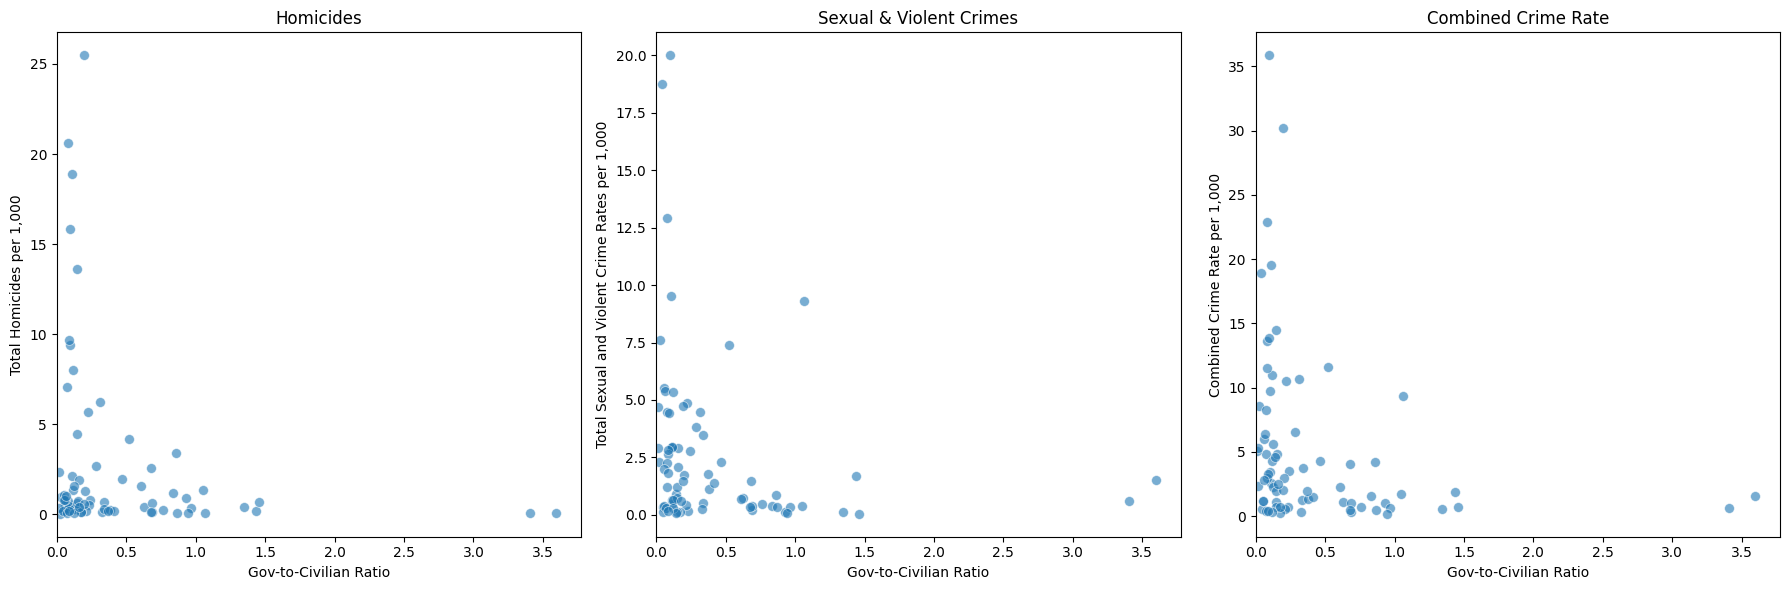

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Apply log transformation to the Gov-to-Civilian Ratio
data["Log_Gov_to_Civilian_Ratio"] = np.log1p(data["Gov_to_Civilian_Ratio"]) 

# Define crime types and titles
crime_types = ["Total Homicides per 1,000", "Total Sexual and Violent Crime Rates per 1,000", "Combined Crime Rate per 1,000"]
titles = ["Homicides", "Sexual & Violent Crimes", "Combined Crime Rate"]

# Scatter plots without regression lines
for i, crime in enumerate(crime_types):
    sns.scatterplot(
        x=data["Log_Gov_to_Civilian_Ratio"],
        y=data[crime],
        alpha=0.6,
        s=50,
        ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Gov-to-Civilian Ratio")
    axes[i].set_ylabel(crime)
    axes[i].set_xlim(0, None)  

plt.tight_layout()
plt.show()